## Cargamos las librerias necesarias

In [16]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras_layer_normalization import LayerNormalization
from tensorflow.keras.activations import relu
from PIL import Image
import imghdr
import seaborn as sns

## Cargamos las imagenes

In [4]:
dirname = os.path.join(os.getcwd(), 'datos')
imgpath = dirname + os.sep 

altura,longitud=100,100 #tamaño pixeles de las imagenes... OJO CON LA CANTIDAD DE PIXELES

directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

def cargar_y_redimensionar_imagenes(ruta):
    imagenes_redimensionadas = []
    for archivo in os.listdir(ruta):
        # Verificamos si el archivo es una imagen válida antes de abrirlo
        tipo_imagen = imghdr.what(os.path.join(ruta, archivo))
        if tipo_imagen in ['jpeg', 'png', 'bmp', 'gif']:
            imagen = Image.open(os.path.join(ruta, archivo))
            imagen = imagen.resize((altura, longitud))
            imagen_array = np.array(imagen)
            # Verificamos que la imagen tenga 3 canales (RGB) antes de agregarla
            if len(imagen_array.shape) == 3 and imagen_array.shape[2] == 3:
                imagenes_redimensionadas.append(imagen_array)
    return imagenes_redimensionadas

# Rutas de los directorios de imágenes
ruta_mercantes = './datos/mercantes'
ruta_otros = './datos/otros'

# Cargar y redimensionar imágenes de mercantes y otros
imagenes_mercantes = cargar_y_redimensionar_imagenes(ruta_mercantes)
imagenes_otros = cargar_y_redimensionar_imagenes(ruta_otros)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  c:\Users\cbalm\iCloudDrive\APN\Tesis\Codigo\datos\
c:\Users\cbalm\iCloudDrive\APN\Tesis\Codigo\datos\mercantes 1
c:\Users\cbalm\iCloudDrive\APN\Tesis\Codigo\datos\otros 54
Directorios leidos: 2
Imagenes en cada directorio [55, 41]
suma Total de imagenes en subdirs: 96


## Crear etiquetas y clases

Creamos los labels con valor 0 para mercante y 1 para otros. 

In [5]:
# Crear una lista de etiquetas (0 para mercantes, 1 para otros)
etiquetas_mercantes = [0] * len(imagenes_mercantes)
etiquetas_otros = [1] * len(imagenes_otros)

# Combinar las imágenes y etiquetas en un solo conjunto de datos
imagenes = imagenes_mercantes + imagenes_otros
etiquetas = etiquetas_mercantes + etiquetas_otros

## Creamos sets de Entrenamiento y Test

In [11]:

# Convertir a arreglos NumPy
X = np.array(imagenes, dtype=np.uint8)
y = np.array(etiquetas)

# Dividir los datos en conjuntos de entrenamiento y validación (80% para entrenamiento, 20% para validación)
train_X, valid_X, train_label, valid_label = train_test_split(X, y, test_size=0.2, random_state=42)

train_X = train_X / 255.
valid_X = valid_X / 255.

# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs:', nClasses)
print('Output classes:', classes)

train_label_one_hot = to_categorical(train_label, num_classes=nClasses)
valid_label_one_hot = to_categorical(valid_label, num_classes=nClasses)

Total number of outputs: 2
Output classes: [0 1]


## Creamos la red neuronal

In [12]:
INIT_LR = 1e-3

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
tamano_filtro1=(3,3)
tamano_filtro2=(2,2)
tamano_pool=(2,2)

modelo = Sequential()
modelo.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#capa que aplana la imagen (1D)
modelo.add(Flatten())

#capa normal, de 256 neuronas
modelo.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo.add(Dropout(0.5))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo.add(Dense(nClasses,activation='softmax'))

modelo.summary()

modelo.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

## Entrenamos la red

In [20]:
epochs = 10
batch_size = 64

history=modelo.fit(train_X, train_label_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label_one_hot))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
dir='./modelo/'

if not os.path.exists(dir):
    os.mkdir(dir)
modelo.save('./modelo/modelo.h5')
modelo.save_weights('./modelo/pesos.h5')

Epoch 1/10
2/2 [==============================] - 1s 342ms/step - loss: 0.1535 - accuracy: 0.9474 - val_loss: 0.3791 - val_accuracy: 0.8421
Epoch 2/10
2/2 [==============================] - 1s 267ms/step - loss: 0.1259 - accuracy: 0.9868 - val_loss: 0.4771 - val_accuracy: 0.8421
Epoch 3/10
2/2 [==============================] - 1s 273ms/step - loss: 0.1220 - accuracy: 0.9605 - val_loss: 0.4490 - val_accuracy: 0.8421
Epoch 4/10
2/2 [==============================] - 1s 270ms/step - loss: 0.1320 - accuracy: 0.9474 - val_loss: 0.3900 - val_accuracy: 0.8421
Epoch 5/10
2/2 [==============================] - 1s 270ms/step - loss: 0.1031 - accuracy: 0.9605 - val_loss: 0.4577 - val_accuracy: 0.8421
Epoch 6/10
2/2 [==============================] - 1s 260ms/step - loss: 0.0850 - accuracy: 0.9868 - val_loss: 0.5602 - val_accuracy: 0.7895
Epoch 7/10
2/2 [==============================] - 1s 266ms/step - loss: 0.0862 - accuracy: 0.9737 - val_loss: 0.4403 - val_accuracy: 0.8421
Epoch 8/10
2/2 [====

## Obtenemos las métricas de entrenamiento y validación, luego graficamos

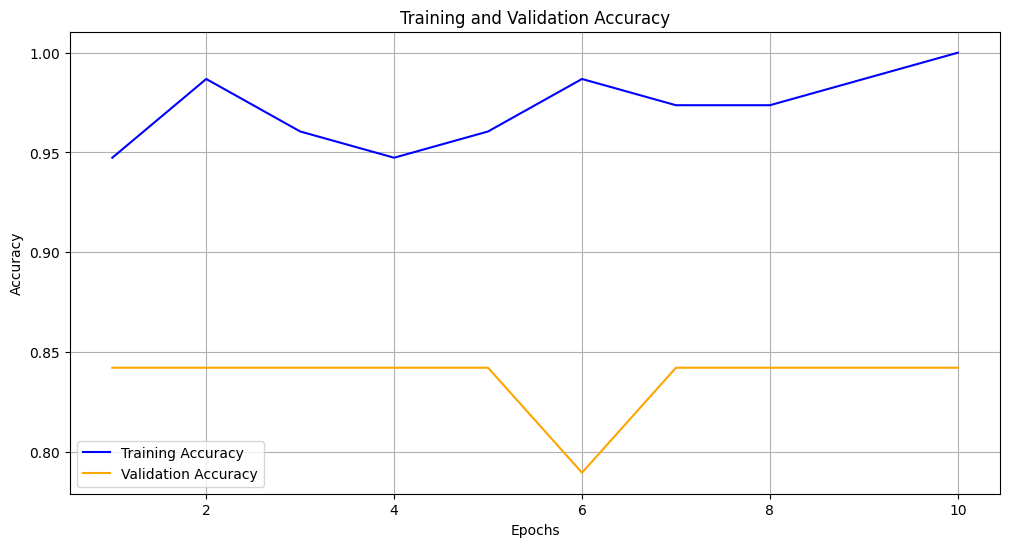

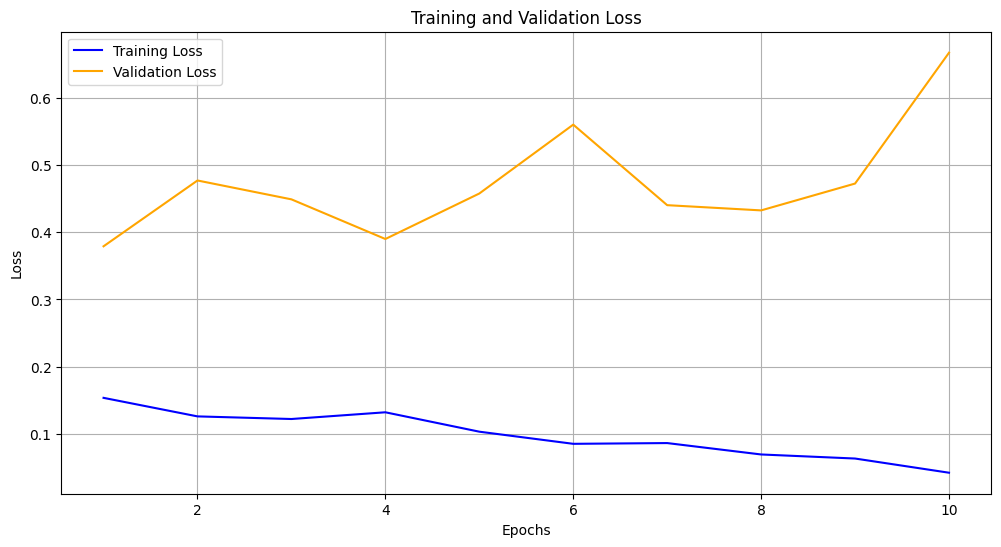

In [22]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

# Gráfica de precisión (accuracy)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de pérdida (loss)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()